In [1]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dropout, Dense, Bidirectional
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from itertools import cycle
from nltk.corpus import stopwords
# Load and Preprocess the dataset (common for both models)
df = pd.read_csv('modified_categorized_reviews14.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y_dict = {'Compatibility and Device Issues': 0, 'Functionality and Features': 1, 'Customer Support and Responsiveness': 2, 'Security and Privacy Concerns': 3, 'User Interface and UX': 4, 'Performance and Stability': 5}
y = df['category'].map(y_dict)
y = pd.get_dummies(df['category']).values

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Define the GRU and BiGRU models
def create_model(gru_type='GRU'):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    if gru_type == 'GRU':
        model.add(GRU(64))
    else: # BiGRU
        model.add(Bidirectional(GRU(64, return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)

# Lists to store average accuracies across folds
gru_avg_train_acc = []
gru_avg_val_acc = []
bigru_avg_train_acc = []
bigru_avg_val_acc = []

# Train GRU and BiGRU Models
for gru_type in ['GRU', 'BiGRU']:
    fold_no = 1
    acc_per_fold = []
    for train, test in kfold.split(X_resampled, y_resampled):
        model = create_model(gru_type)
        history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
        
        if gru_type == 'GRU':
            gru_avg_train_acc.append(history.history['accuracy'])
            gru_avg_val_acc.append(history.history['val_accuracy'])
        else: # BiGRU
            bigru_avg_train_acc.append(history.history['accuracy'])
            bigru_avg_val_acc.append(history.history['val_accuracy'])

        scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
        acc_per_fold.append(scores[1] * 100)
        fold_no += 1

    print(f'> {gru_type} - Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

    # Assign the last trained model to a variable for ROC calculation
    if gru_type == 'GRU':
        gru_model = model
    else: # BiGRU
        bigru_model = model




> GRU - Average Accuracy across 10-folds: 91.41% (+/- 0.78%)


> BiGRU - Average Accuracy across 10-folds: 92.01% (+/- 0.77%)


765/765 [==============================] - 12s 9ms/step


/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_23563/2245545231.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


765/765 [==============================] - 23s 30ms/step


/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_23563/2245545231.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


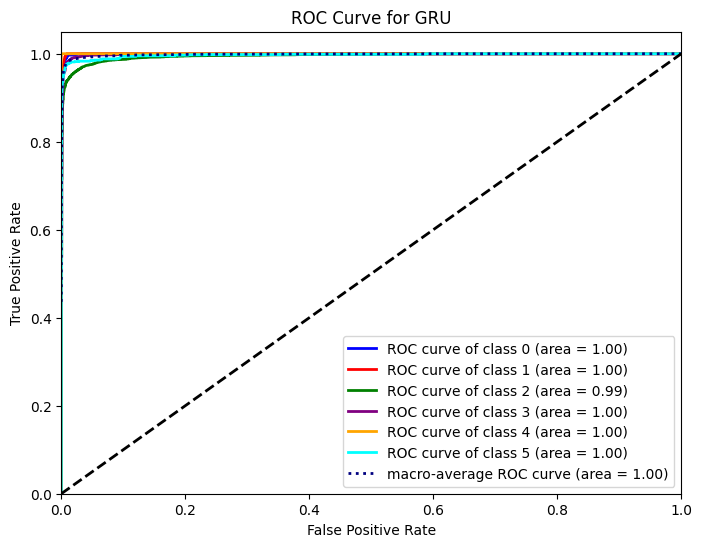

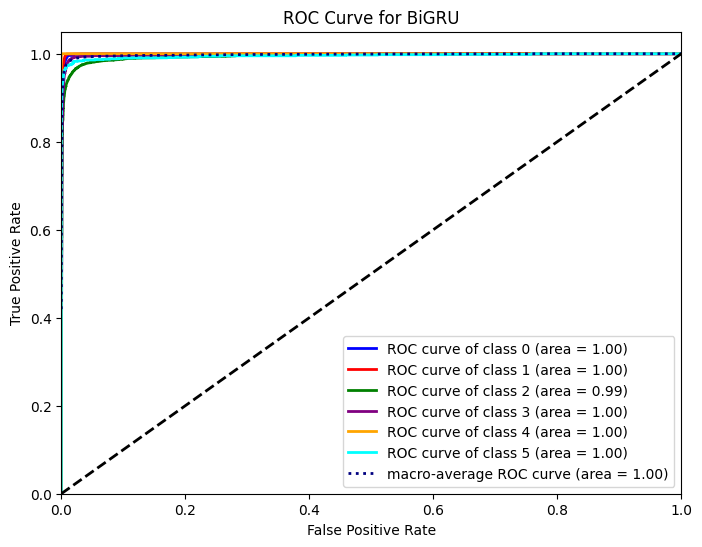

In [6]:
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle

# Function to calculate ROC Curve for each class
def compute_roc_auc(model, X, y, n_classes):
    # Predict probabilities
    y_pred = model.predict(X)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally, average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

# Plot ROC Curve
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot(fpr["macro"], tpr["macro"], color='navy', lw=2, linestyle=':', label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Number of classes
n_classes = y_resampled.shape[1]

# Compute ROC for GRU and BiGRU models
fpr_gru, tpr_gru, roc_auc_gru = compute_roc_auc(gru_model, X_resampled, y_resampled, n_classes)
fpr_bigru, tpr_bigru, roc_auc_bigru = compute_roc_auc(bigru_model, X_resampled, y_resampled, n_classes)

# Plot ROC Curve for GRU
plot_roc_curve(fpr_gru, tpr_gru, roc_auc_gru, 'ROC Curve for GRU')

# Plot ROC Curve for BiGRU
plot_roc_curve(fpr_bigru, tpr_bigru, roc_auc_bigru, 'ROC Curve for BiGRU')


In [11]:
def plot_roc_curve(fpr, tpr, roc_auc, title, filename):
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot(fpr["macro"], tpr["macro"], color='navy', lw=2, linestyle=':', label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    # Save the figure
    plt.savefig(filename, dpi=300)
    plt.show()


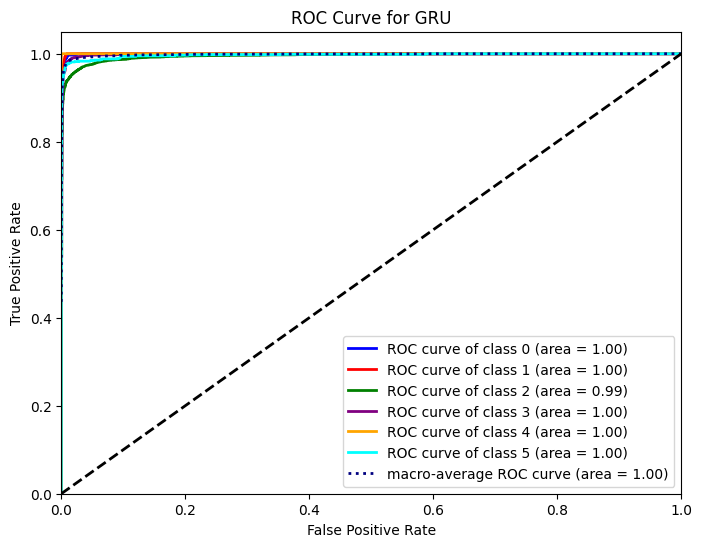

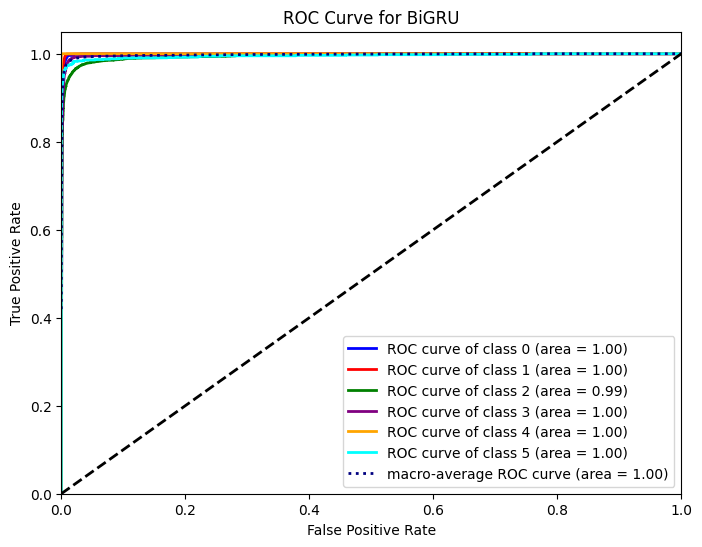

In [12]:
# Plot and save ROC Curve for GRU
plot_roc_curve(fpr_gru, tpr_gru, roc_auc_gru, 'ROC Curve for GRU', 'roc_curve_gru.png')

# Plot and save ROC Curve for BiGRU
plot_roc_curve(fpr_bigru, tpr_bigru, roc_auc_bigru, 'ROC Curve for BiGRU', 'roc_curve_bigru.png')


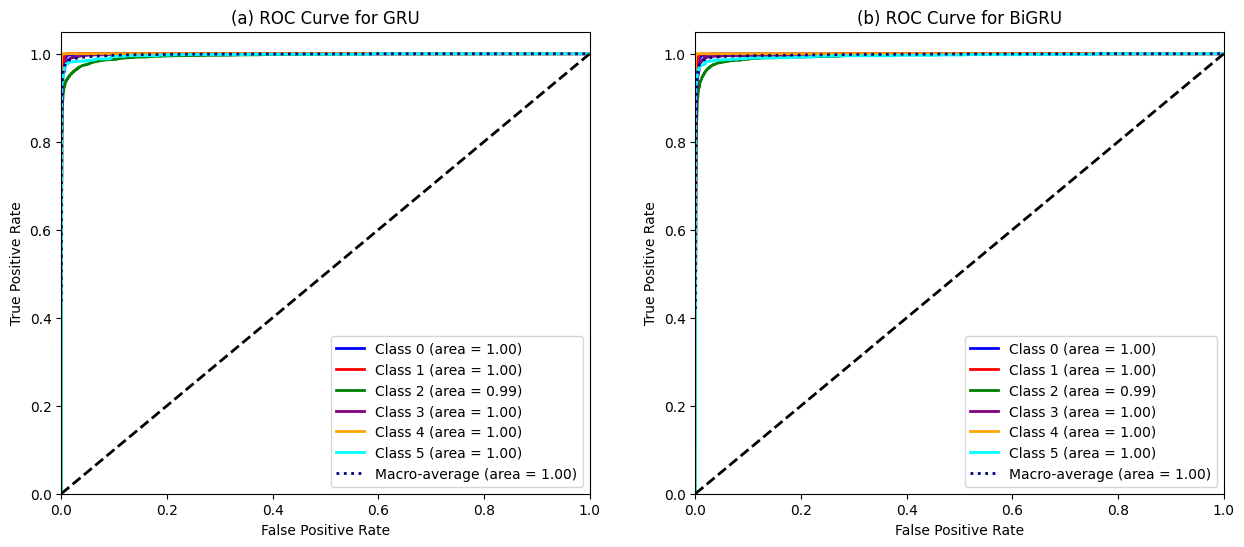

In [14]:
import matplotlib.pyplot as plt
from itertools import cycle

def plot_combined_roc_curve(fpr_gru, tpr_gru, roc_auc_gru, fpr_bigru, tpr_bigru, roc_auc_bigru, n_classes):
    plt.figure(figsize=(15, 6))

    # Subplot for GRU ROC Curve
    plt.subplot(1, 2, 1)
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr_gru[i], tpr_gru[i], color=color, lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc_gru[i]))
    plt.plot(fpr_gru["macro"], tpr_gru["macro"], color='navy', lw=2, linestyle=':', label='Macro-average (area = {0:0.2f})'.format(roc_auc_gru["macro"]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('(a) ROC Curve for GRU')
    plt.legend(loc="lower right")

    # Subplot for BiGRU ROC Curve
    plt.subplot(1, 2, 2)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr_bigru[i], tpr_bigru[i], color=color, lw=2, label='Class {0} (area = {1:0.2f})'.format(i, roc_auc_bigru[i]))
    plt.plot(fpr_bigru["macro"], tpr_bigru["macro"], color='navy', lw=2, linestyle=':', label='Macro-average (area = {0:0.2f})'.format(roc_auc_bigru["macro"]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('(b) ROC Curve for BiGRU')
    plt.legend(loc="lower right")

    # Save the combined figure
    plt.savefig('combined_roc_curves.png', dpi=300)
    plt.show()

# Call the function with the ROC data
plot_combined_roc_curve(fpr_gru, tpr_gru, roc_auc_gru, fpr_bigru, tpr_bigru, roc_auc_bigru, n_classes)


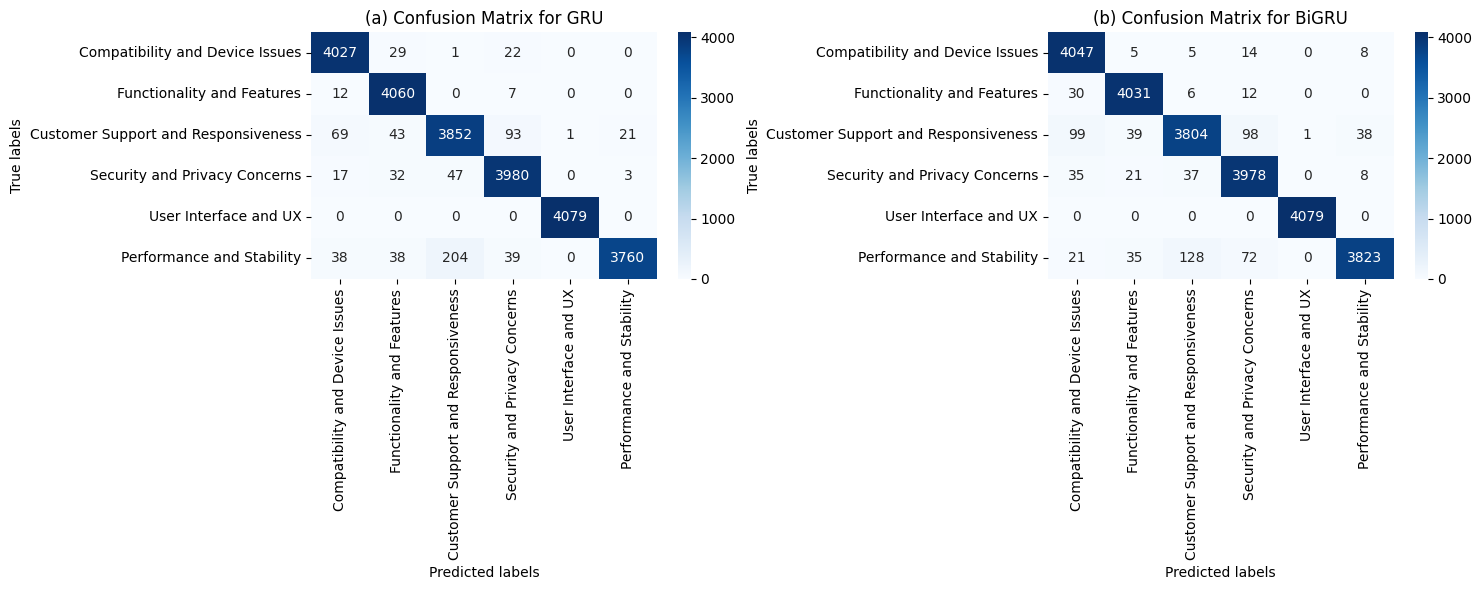

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_confusion_matrix(cm_gru, cm_bigru, labels):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Confusion Matrix for GRU
    sns.heatmap(cm_gru, ax=axes[0], annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    axes[0].set_title('(a) Confusion Matrix for GRU')
    axes[0].set_xlabel('Predicted labels')
    axes[0].set_ylabel('True labels')

    # Confusion Matrix for BiGRU
    sns.heatmap(cm_bigru, ax=axes[1], annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    axes[1].set_title('(b) Confusion Matrix for BiGRU')
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('True labels')

    plt.tight_layout()
    plt.savefig('combined_confusion_matrices1.png', dpi=300)
    plt.show()

# Generate confusion matrices
cm_gru = confusion_matrix(y_true_classes, y_pred_classes_gru)
cm_bigru = confusion_matrix(y_true_classes, y_pred_classes_bigru)

# Category labels (replace this with your category names)
labels = list(y_dict.keys())

# Call the function to plot combined confusion matrices
plot_combined_confusion_matrix(cm_gru, cm_bigru, labels)


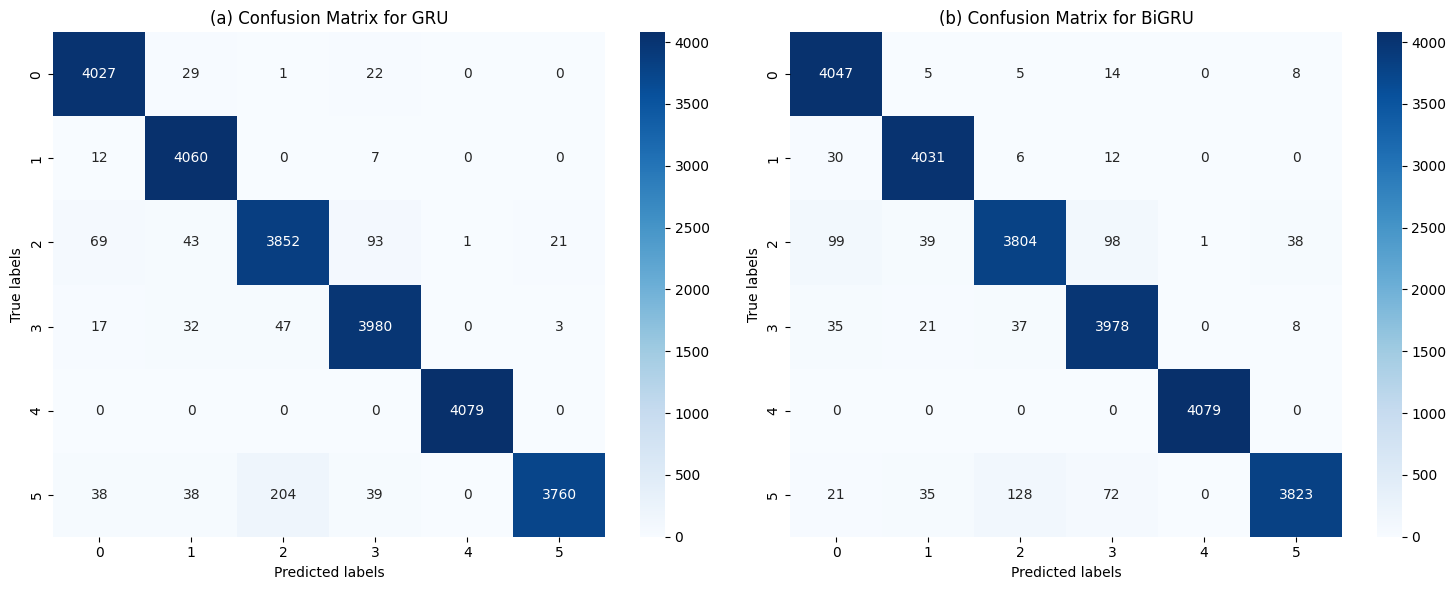

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_confusion_matrix(cm_gru, cm_bigru):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Confusion Matrix for GRU
    sns.heatmap(cm_gru, ax=axes[0], annot=True, fmt='d', cmap='Blues')
    axes[0].set_title('(a) Confusion Matrix for GRU')
    axes[0].set_xlabel('Predicted labels')
    axes[0].set_ylabel('True labels')

    # Confusion Matrix for BiGRU
    sns.heatmap(cm_bigru, ax=axes[1], annot=True, fmt='d', cmap='Blues')
    axes[1].set_title('(b) Confusion Matrix for BiGRU')
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('True labels')

    plt.tight_layout()
    plt.savefig('combined_confusion_matrices.png', dpi=300)
    plt.show()

# Generate confusion matrices
cm_gru = confusion_matrix(y_true_classes, y_pred_classes_gru)
cm_bigru = confusion_matrix(y_true_classes, y_pred_classes_bigru)

# Call the function to plot combined confusion matrices
plot_combined_confusion_matrix(cm_gru, cm_bigru)


765/765 [==============================] - 8s 10ms/step
Classification Report for GRU Model:
                                     precision    recall  f1-score   support

    Compatibility and Device Issues       0.97      0.99      0.98      4079
         Functionality and Features       0.97      1.00      0.98      4079
Customer Support and Responsiveness       0.94      0.94      0.94      4079
      Security and Privacy Concerns       0.96      0.98      0.97      4079
              User Interface and UX       1.00      1.00      1.00      4079
          Performance and Stability       0.99      0.92      0.96      4079

                           accuracy                           0.97     24474
                          macro avg       0.97      0.97      0.97     24474
                       weighted avg       0.97      0.97      0.97     24474



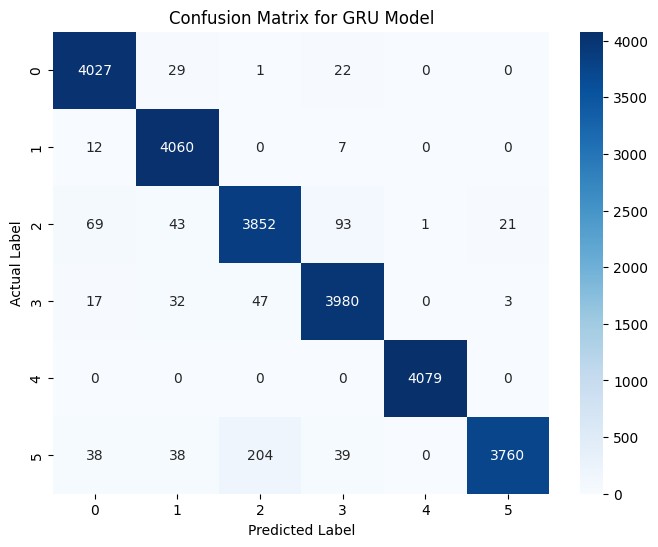

765/765 [==============================] - 16s 21ms/step
Classification Report for BiGRU Model:
                                     precision    recall  f1-score   support

    Compatibility and Device Issues       0.96      0.99      0.97      4079
         Functionality and Features       0.98      0.99      0.98      4079
Customer Support and Responsiveness       0.96      0.93      0.94      4079
      Security and Privacy Concerns       0.95      0.98      0.96      4079
              User Interface and UX       1.00      1.00      1.00      4079
          Performance and Stability       0.99      0.94      0.96      4079

                           accuracy                           0.97     24474
                          macro avg       0.97      0.97      0.97     24474
                       weighted avg       0.97      0.97      0.97     24474



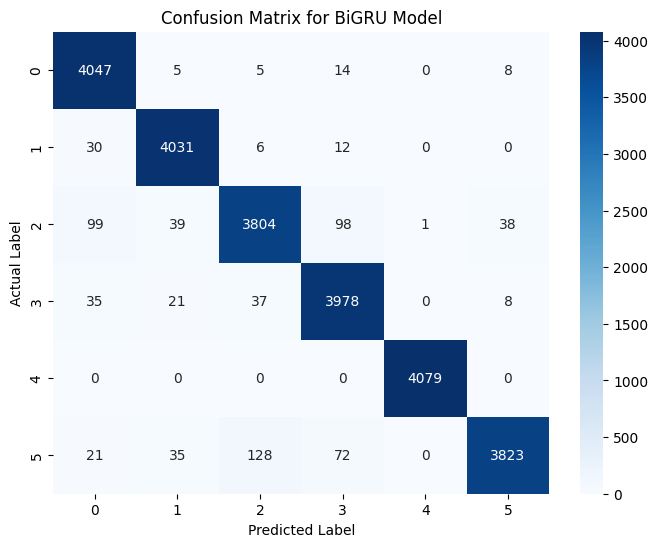

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Generate classification report and confusion matrix for GRU Model
y_pred_gru = gru_model.predict(X_resampled)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)

print("Classification Report for GRU Model:")
print(classification_report(y_true_classes, y_pred_classes_gru, target_names=list(y_dict.keys())))

cm_gru = confusion_matrix(y_true_classes, y_pred_classes_gru)
plot_confusion_matrix(cm_gru, "Confusion Matrix for GRU Model")

# Generate classification report and confusion matrix for BiGRU Model
y_pred_bigru = bigru_model.predict(X_resampled)
y_pred_classes_bigru = np.argmax(y_pred_bigru, axis=1)

print("Classification Report for BiGRU Model:")
print(classification_report(y_true_classes, y_pred_classes_bigru, target_names=list(y_dict.keys())))

cm_bigru = confusion_matrix(y_true_classes, y_pred_classes_bigru)
plot_confusion_matrix(cm_bigru, "Confusion Matrix for BiGRU Model")


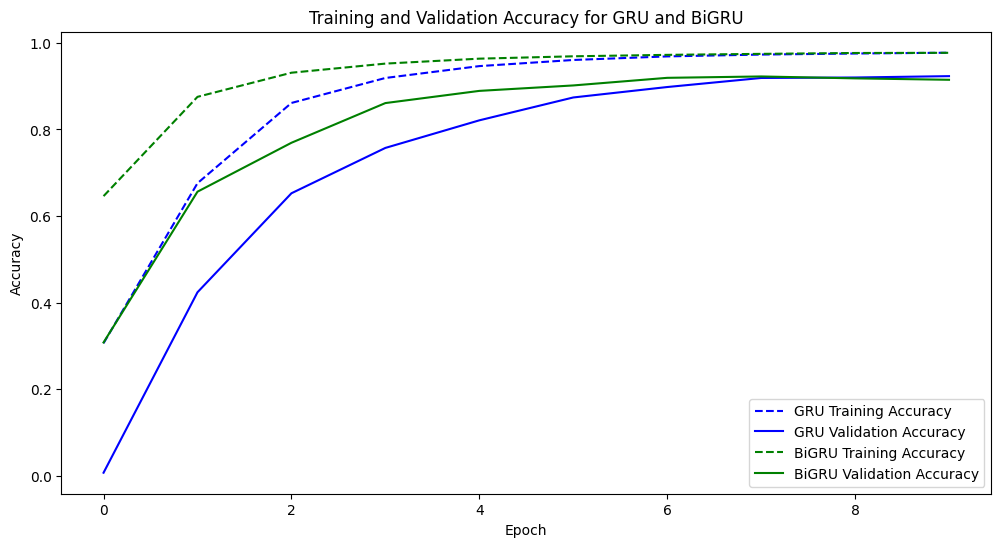

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(np.mean(gru_avg_train_acc, axis=0), label='GRU Training Accuracy', color='blue', linestyle='dashed')
plt.plot(np.mean(gru_avg_val_acc, axis=0), label='GRU Validation Accuracy', color='blue')
plt.plot(np.mean(bigru_avg_train_acc, axis=0), label='BiGRU Training Accuracy', color='green', linestyle='dashed')
plt.plot(np.mean(bigru_avg_val_acc, axis=0), label='BiGRU Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy for GRU and BiGRU')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


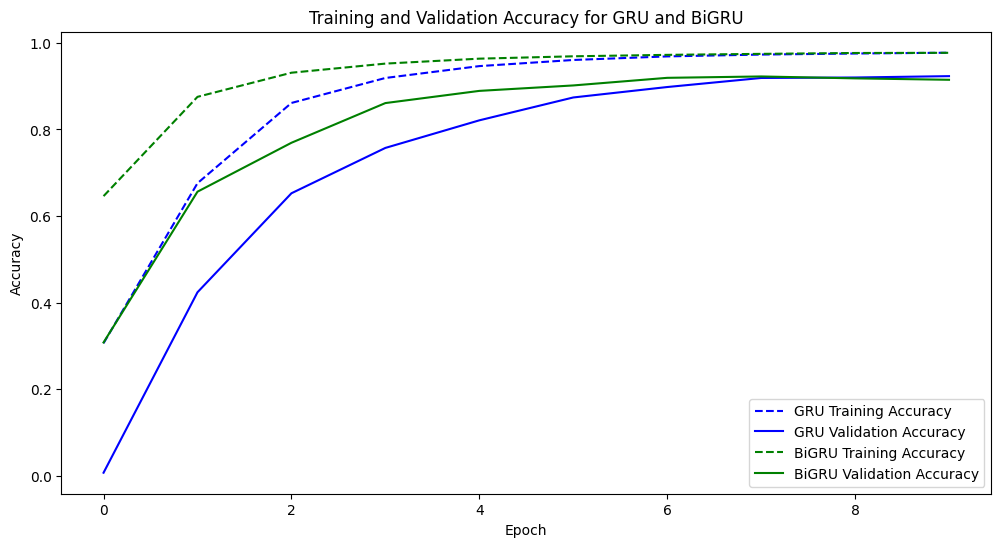

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(np.mean(gru_avg_train_acc, axis=0), label='GRU Training Accuracy', color='blue', linestyle='dashed')
plt.plot(np.mean(gru_avg_val_acc, axis=0), label='GRU Validation Accuracy', color='blue')
plt.plot(np.mean(bigru_avg_train_acc, axis=0), label='BiGRU Training Accuracy', color='green', linestyle='dashed')
plt.plot(np.mean(bigru_avg_val_acc, axis=0), label='BiGRU Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy for GRU and BiGRU')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the figure in high resolution
plt.savefig('training_validation_accuracy.png', dpi=300)

plt.show()
